# ARIMA | Forecasting inflation in Poland

I chose the ARIMA method for forecasting inflation because it takes into account both autoregressive relationships, reflecting the relationship between current and previous inflation values, and moving average components, taking into account the impact of random disturbances. This method is used in the code below to forecast inflation based on historical data after logarithmic transformation and differentiating the data to obtain a stationary time series.

The data comes from the official website of the Central Statistical Office

In [1]:
import pandas as pd
import numpy as np

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     280 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


<Axes: >

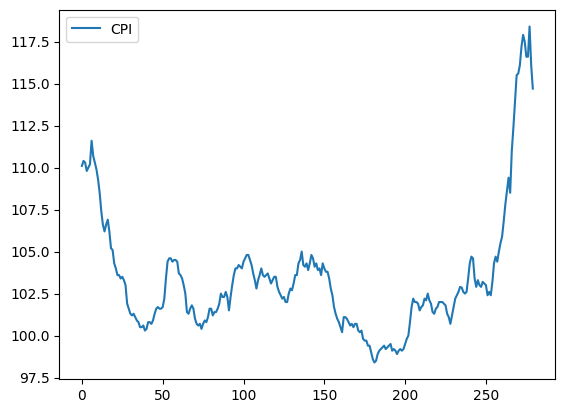

In [2]:
df = pd.read_excel('/Users/weronikakieliszek/Desktop/Uni/Masters/2nd Semester/Data Science/ARIMA_Data.xlsx')

df.info()
df.plot()

<Axes: >

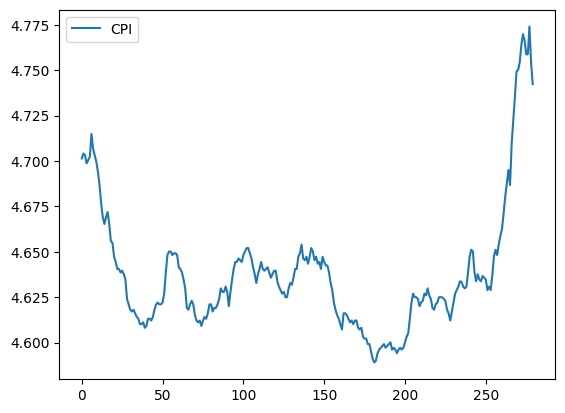

In [3]:
df = np.log(df)
df.plot()

In [4]:
msk = (df.index < len(df)-12)
df_train = df[msk].copy()
df_test = df[~msk].copy()

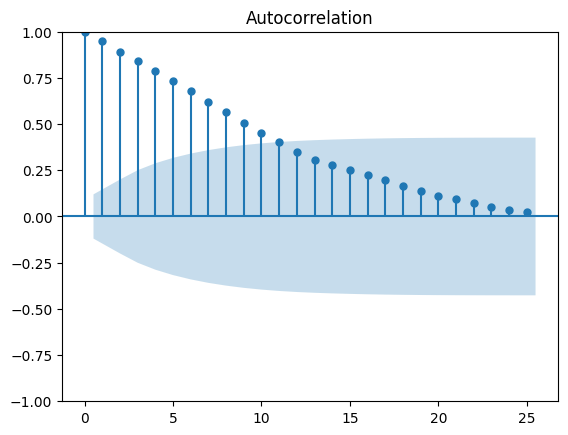

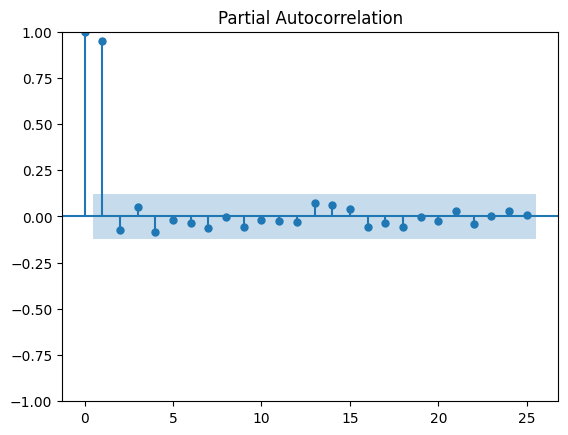

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

In [6]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

# I check if my time series is stationary, a very high p-value suggests it is not

p-value: 0.8442684404341401


<Axes: >

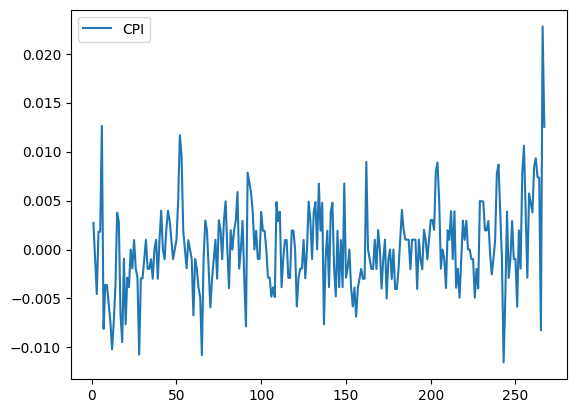

In [7]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

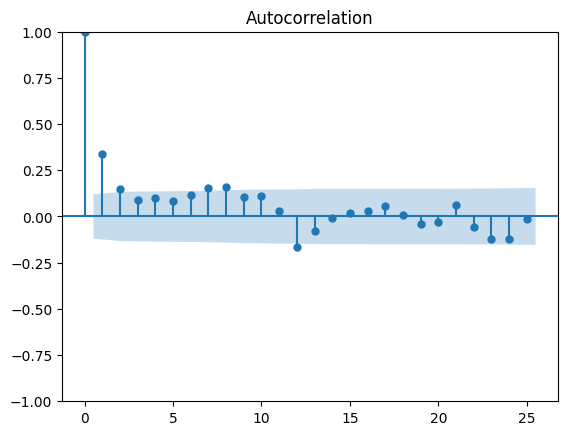

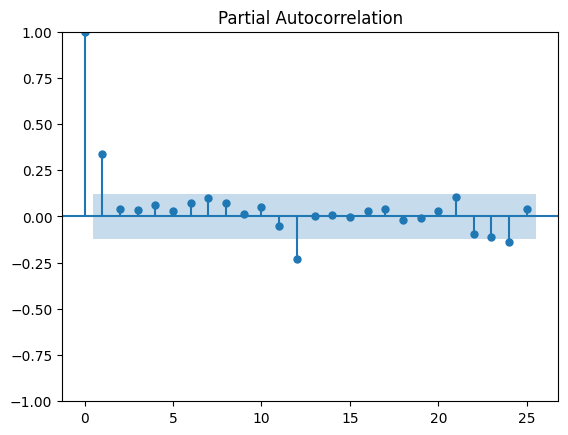

In [8]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [9]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

# After the transformation, we can assume that the time series is stationary

p-value: 0.012432521720199506


In [10]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  268
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1089.960
Date:                Mon, 10 Jun 2024   AIC                          -2173.921
Time:                        09:50:07   BIC                          -2163.159
Sample:                             0   HQIC                         -2169.598
                                - 268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3283      0.050      6.551      0.000       0.230       0.427
ar.L2          0.0660      0.060      1.095      0.273      -0.052       0.184
sigma2      1.663e-05   9.96e-07     16.690      0.0

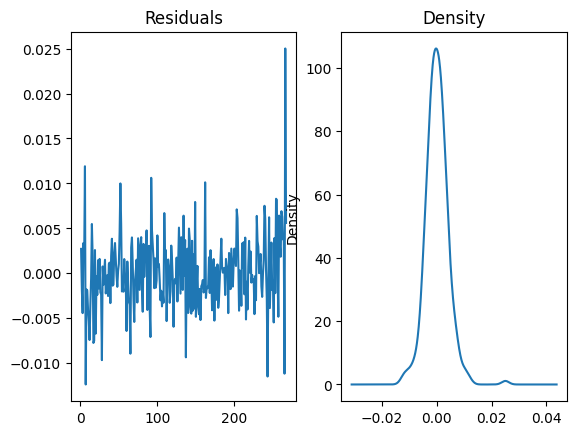

In [11]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

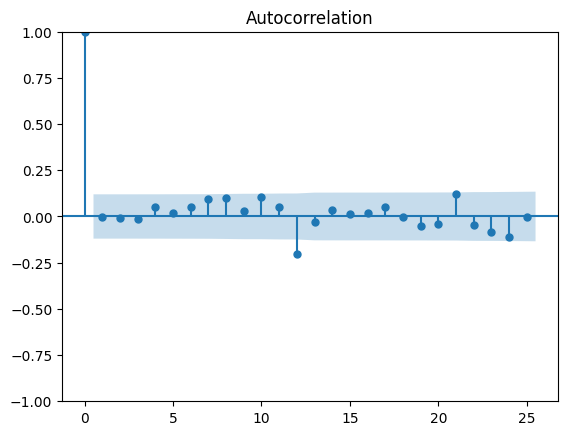

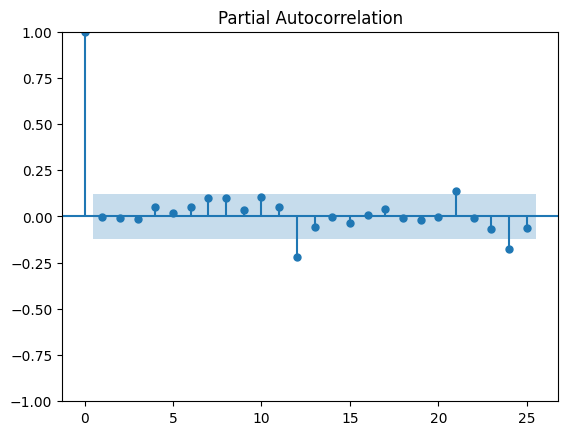

In [12]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

<Axes: >

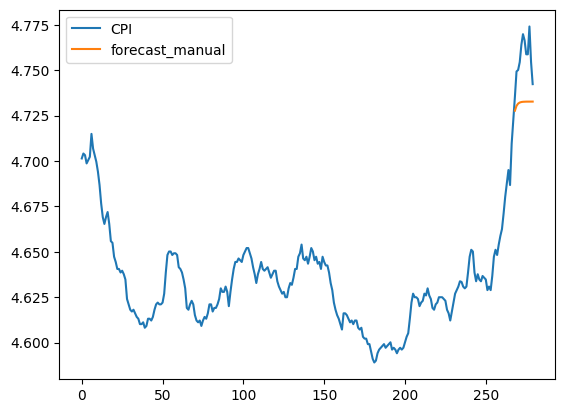

In [13]:
forecast_test = model_fit.forecast(len(df_test))
df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)
df.plot()

In [14]:
import pmdarima as pm

auto_arima = pm.auto_arima(df_train, stepwise=True, seasonal=True)
auto_arima

ARIMA(order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [15]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  268
Model:               SARIMAX(1, 2, 1)   Log Likelihood                1085.678
Date:                Mon, 10 Jun 2024   AIC                          -2165.355
Time:                        09:50:09   BIC                          -2154.605
Sample:                             0   HQIC                         -2161.036
                                - 268                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2638      0.054      4.858      0.000       0.157       0.370
ma.L1         -0.9410      0.024    -38.495      0.000      -0.989      -0.893
sigma2      1.657e-05   1.07e-06     15.457      0.000    1.45e-05    1.87e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               194.56
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.50
Prob(H) (two-sided):                  0.19   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

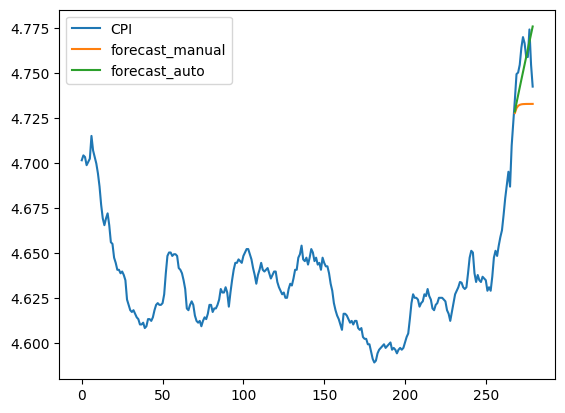

In [16]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot()

In [17]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.0245558219398397
mape - manual: 0.005157945527116163
rmse - manual: 0.026468562344452988


In [18]:
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 0.013207021641165717
mape - auto: 0.002777513915061
rmse - auto: 0.01559681097845034


In [19]:
df

,CPI,forecast_manual,forecast_auto
0,4.701389,NaN,NaN
1,4.704110,NaN,NaN
2,4.703204,NaN,NaN
3,4.698661,NaN,NaN
4,4.700480,NaN,NaN
...,...,...,...
275,4.758749,4.732680,4.758830
276,4.758749,4.732693,4.763054
277,4.774069,4.732699,4.767277
278,4.754452,4.732702,4.771501


In [20]:
auto_arima = pm.auto_arima(df['CPI'], stepwise=True, seasonal=True)
auto_arima

ARIMA(order=(0, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [21]:
forecast = auto_arima.predict(n_periods=1)

In [22]:
forecast = np.exp(forecast)

In [23]:
forecast = round(forecast[280]-100,2)
print(forecast)

14.47


In [24]:
print(f"The inflation forecast for May 2023 is {forecast}%.")

The inflation forecast for May 2023 is 14.47%.
